In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os

import logging as log

%matplotlib inline

In [2]:
log.getLogger().setLevel(20)

In [3]:
all_params = {}
all_runs = None

def get_params(run):
    result = {}
    params = ds[ds.type == "param"]
    for index, row in params[params.run == run].iterrows():
        # Try conversion. If fail, store string
        try:
            result[row.attrname] = float(row.attrvalue)
        except ValueError:
            result[row.attrname] = row.attrvalue
    return result

def build_params(ds):
    global all_params, all_runs
    
    all_params = {}
    all_runs = ds.run.unique()
    for run in all_runs:       
        all_params[run] = get_params(run)

In [4]:
os.system("scavetool x ../results/*.vec ../results/*.sca -o /tmp/measurements.csv")
ds = pd.read_csv("/tmp/measurements.csv")
build_params(ds)

In [5]:
def find_run(**params):
    global ds
    
    result = None
    
    for run in all_runs:       
        run_params = all_params[run]
                
        for name, value in params.items():
            if type(value) is str:
                check_value = '"'+value+'"'
            else:
                check_value = value
                
            if name not in run_params or run_params[name] != check_value:
                log.debug(f"{run_params} fails {name}, expected {check_value}, found {run_params[name] if name in run_params else 'None'}")
                break
        else: # loop was not interrupted 
            if result is None:
                result = run
            else:
                log.warning("Provided parameters match multiple runs.")
                
    return result
    

In [6]:
def get_scalar(run, module, name):
    strvalue = ds[(ds.type == "scalar") & (ds.run == run) & (ds.name == name) & (ds.module == module)].iloc[0].value
    try:
        return float(strvalue)
    except ValueError:
        log.warning("Scalar is not a number: " + strvalue)
        return strvalue

def get_avg_rt(run, vip, compound):
    if run is None:
        log.error("Provided run is None")
        return None
                          
    name = ""
    if compound:
        name += "compound"
    else:
        name += "simple"

    if vip:
        name += "Vip"
    else:
        name += "Normal"

    name += "ResponseTime:mean"
    
    module = "Network.exit"
                          
    return get_scalar(run, module, name)

def get_avg_wt(run, module, vip):
    if run is None:
        log.error("Provided run is None")
        return None
                          
    name = ""

    if vip:
        name += "vip"
    else:
        name += "normal"

    name += "WaitingTime:mean"
    
    return get_scalar(run, module, name)

def get_avg_nq(run, module, vip = False, fifo = False):
    if run is None:
        log.error("Provided run is None")
        return None
                          
    name = ""

    if fifo:
        name += "fifo"
    elif vip:
        name += "vip"
    else:
        name += "normal"

    name += "QueueLength:timeavg"
    
    return get_scalar(run, module, name)
          

In [7]:
def get_vector(run, module, name):
    try:
        return np.fromstring(ds[(ds.type == "vector") & (ds.run == run) & (ds.name == name) & (ds.module == module)].iloc[0].vecvalue, 
                             sep=" ", dtype=np.double)
    except Exception:
        log.warning("No vector found")
        return np.array([])

def get_rt(run, vip, compound):
    if run is None:
        log.error("Provided run is None")
        return None
                          
    name = ""
    if compound:
        name += "compound"
    else:
        name += "simple"

    if vip:
        name += "Vip"
    else:
        name += "Normal"

    name += "ResponseTime:vector"
    
    module = "Network.exit"
                          
    return get_vector(run, module, name)

def get_wt(run, module, vip):
    if run is None:
        log.error("Provided run is None")
        return None
                          
    name = ""

    if vip:
        name += "vip"
    else:
        name += "normal"

    name += "WaitingTime:vector"
    
    return get_vector(run, module, name)

In [8]:
def hol_wait_time(vip, normArrivalRate, vipArrivalRate, serviceRate):
    if not vip:
        return ((normArrivalRate + vipArrivalRate)/((serviceRate-vipArrivalRate)*(serviceRate-normArrivalRate-vipArrivalRate)))
    else:
        return ((normArrivalRate + vipArrivalRate)/(serviceRate*(serviceRate-vipArrivalRate)))
    
def hol_resp_time(vip, normArrivalRate, vipArrivalRate, serviceRate):
    return hol_wait_time(vip, normArrivalRate, vipArrivalRate, serviceRate) + 1 / serviceRate

In [25]:
def mm1_resp_time(arrivalRate, serviceRate):
    return 1/(serviceRate - arrivalRate)

def mm1_wait_time(arrivalRate, serviceRate):
    return mm1_resp_time(arrivalRate, serviceRate) - 1/serviceRate

def mm1_queue_length(arrivalRate, serviceRate):
    rho = arrivalRate/serviceRate
    return rho/(1-rho)-rho

(array([6.93547316e-02, 3.12341318e-02, 1.41606726e-02, 6.86776922e-03,
        2.97346959e-03, 1.29904070e-03, 6.66807964e-04, 3.06943348e-04,
        1.42181804e-04, 3.38696108e-05]),
 array([1.00528360e-05, 7.87157024e+00, 1.57431304e+01, 2.36146906e+01,
        3.14862508e+01, 3.93578110e+01, 4.72293712e+01, 5.51009313e+01,
        6.29724915e+01, 7.08440517e+01, 7.87156119e+01]),
 <a list of 10 Patch objects>)

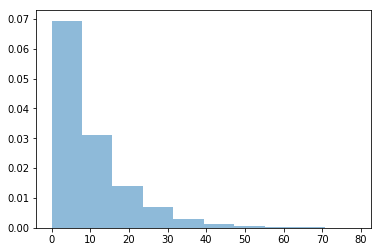

In [10]:
p = plt.axes()
params = {
#     "**.randFunc": "exp",
    "**.cashier.rate": 1.1,
#     "**.kitchen.rate": 0.2,
    "**.customerSpawn.normalRate": 1,
#     "**.customerSpawn.vipRate": 0,
#     "**.customerSpawn.pCompound": 0,
}
run = find_run(**params)

p.hist(get_rt(run, False, False), density=True, alpha=0.5)
# p.hist(get_rt(run, True, False), density=True, alpha=0.5)

# Test 4

## Response Time (mean)

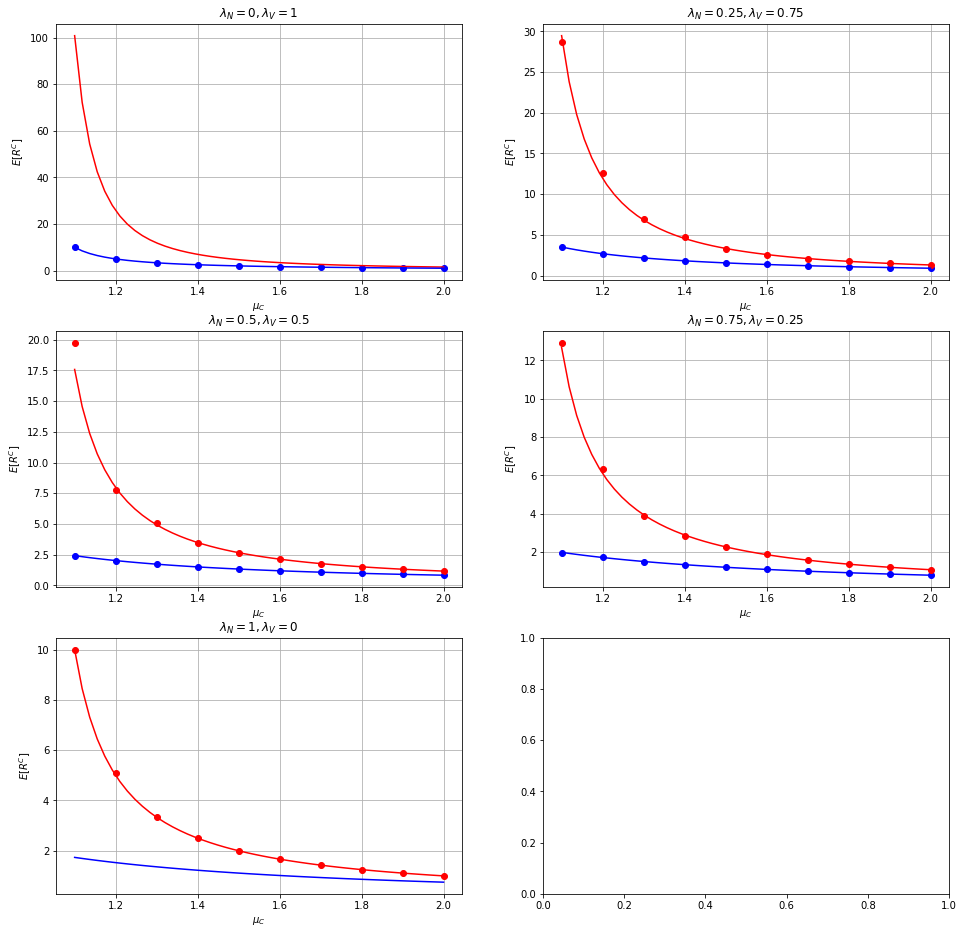

In [11]:
ROWS = 3
COLS = 2

fig, axs = plt.subplots(ROWS, COLS)
fig.set_figheight(16)
fig.set_figwidth(16)

for i, normalRate in enumerate([0, 0.25, 0.5, 0.75, 1]):
    y = i % COLS
    x = i // COLS
    p = axs[x,y]
    
    vipRate = 1 - normalRate
    
    p.set_title(f"$\lambda_N={normalRate}, \lambda_V={vipRate}$")
    p.set_xlabel("$\mu_C$")
    p.set_ylabel("$E[R^C]$")

    params = {
        "**.randFunc": "exp",
        "**.customerSpawn.normalRate": normalRate,
        "**.customerSpawn.pCompound": 0,
    }

    for rate in [1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2]:
        params["**.cashier.rate"] = rate
        for vip in [True, False]:
            avg = get_avg_rt(find_run(**params), vip, False)

            p.plot(rate, avg, ('bo' if vip else 'ro'))

    rates = np.linspace(1.1,2)
    p.plot(rates, hol_resp_time(False, normalRate, vipRate, rates), 'r-')
    p.plot(rates, hol_resp_time(True, normalRate, vipRate, rates), 'b-')
    
    p.grid(True, 'both')

## Response Time (p90)

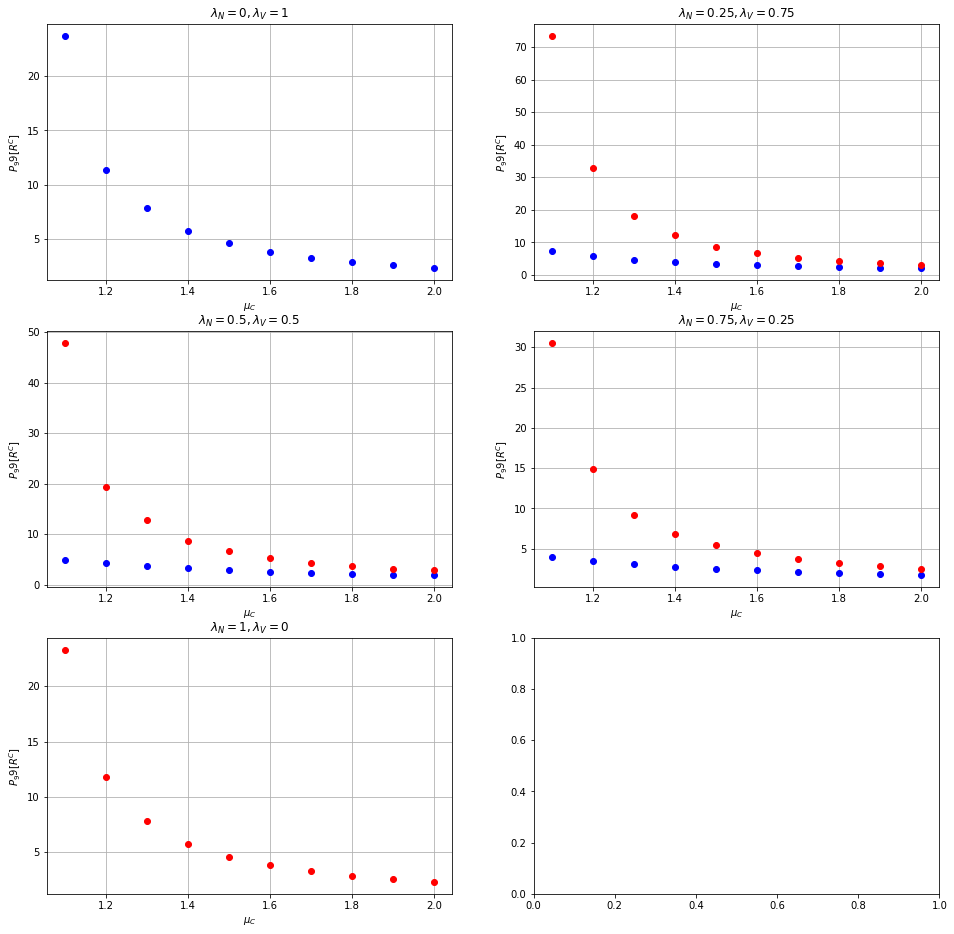

In [12]:
ROWS = 3
COLS = 2

fig, axs = plt.subplots(ROWS, COLS)
fig.set_figheight(16)
fig.set_figwidth(16)

for i, normalRate in enumerate([0, 0.25, 0.5, 0.75, 1]):
    y = i % COLS
    x = i // COLS
    p = axs[x,y]

    vipRate = 1 - normalRate

    p.set_title(f"$\lambda_N={normalRate}, \lambda_V={vipRate}$")
    p.set_xlabel("$\mu_C$")
    p.set_ylabel("$P_99[R^C]$")

    params = {
        "**.randFunc": "exp",
        "**.cashier.rate": 1.1,
        "**.customerSpawn.normalRate": normalRate,
        "**.customerSpawn.pCompound": 0,
    }

    for rate in [1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2]:
        params["**.cashier.rate"] = rate
        for vip in [True, False]:
            arr = get_rt(find_run(**params), vip, False)
            if arr.size == 0:
                continue
            p90 = np.percentile(arr, 90)

            p.plot(rate, p90, ('bo' if vip else 'ro'))
        
        p.grid(True, 'both')

## Waiting Time

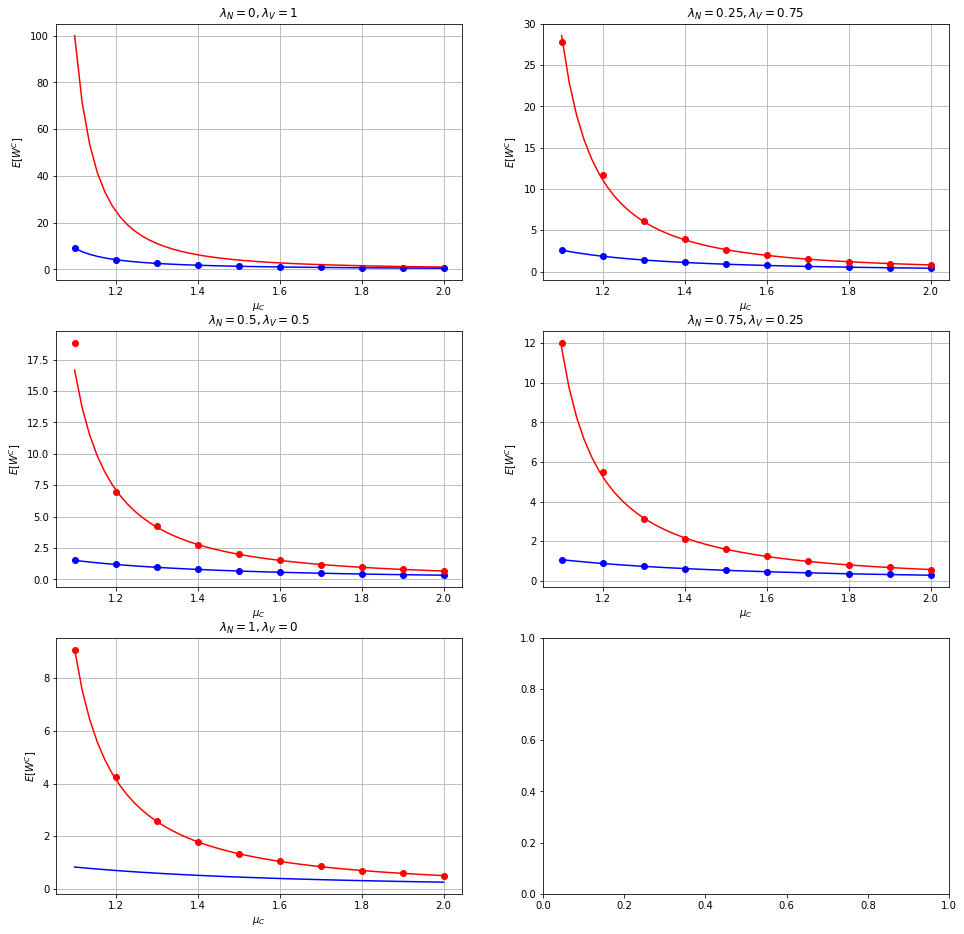

In [13]:
ROWS = 3
COLS = 2

fig, axs = plt.subplots(ROWS, COLS)
fig.set_figheight(16)
fig.set_figwidth(16)

for i, normalRate in enumerate([0, 0.25, 0.5, 0.75, 1]):
    y = i % COLS
    x = i // COLS
    p = axs[x,y]
    
    vipRate = 1 - normalRate
    
    p.set_title(f"$\lambda_N={normalRate}, \lambda_V={vipRate}$")
    p.set_xlabel("$\mu_C$")
    p.set_ylabel("$E[W^C]$")

    params = {
        "**.randFunc": "exp",
        "**.cashier.rate": 1.1,
        "**.customerSpawn.normalRate": normalRate,
        "**.customerSpawn.pCompound": 0,
    }

    for rate in [1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2]:
        params["**.cashier.rate"] = rate
        for vip in [True, False]:
            avg = get_avg_wt(find_run(**params), 'Network.cashier', vip)

            p.plot(rate, avg, ('bo' if vip else 'ro'))

    rates = np.linspace(1.1,2)
    p.plot(rates, hol_wait_time(False, normalRate, vipRate, rates), 'r-')
    p.plot(rates, hol_wait_time(True, normalRate, vipRate, rates), 'b-')
    
    p.grid(True, 'both')

## Queue Length

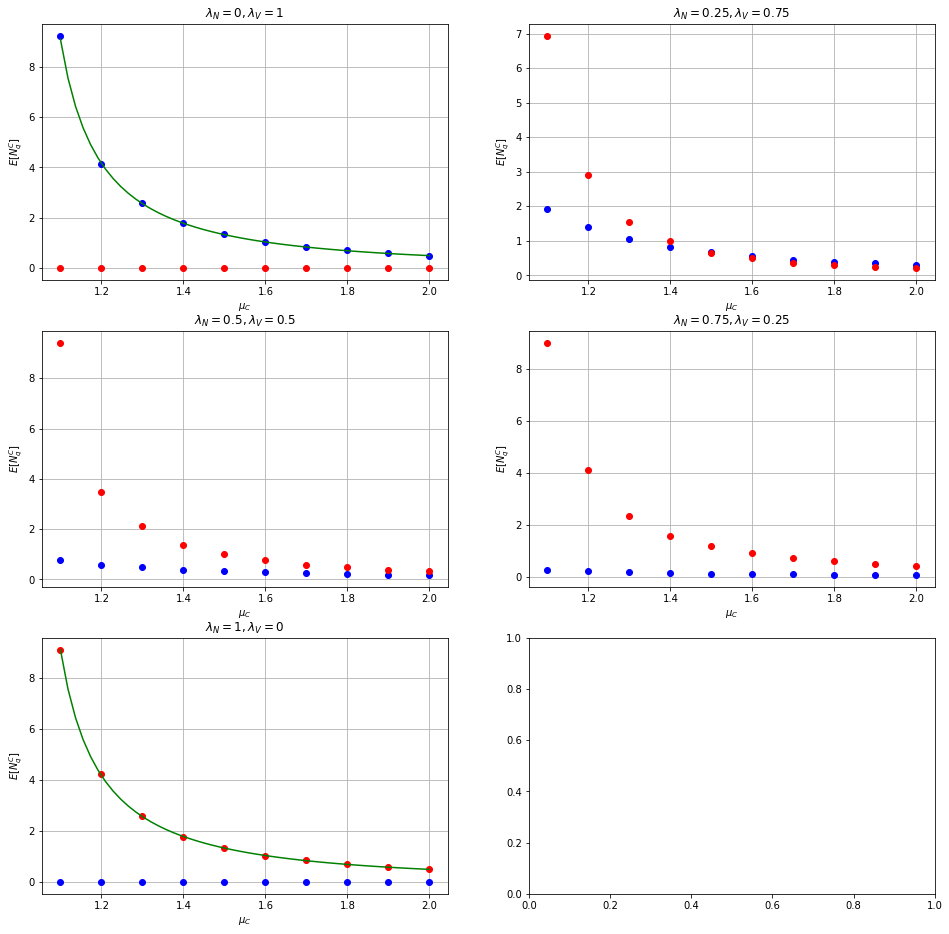

In [14]:
ROWS = 3
COLS = 2

fig, axs = plt.subplots(ROWS, COLS)
fig.set_figheight(16)
fig.set_figwidth(16)

for i, normalRate in enumerate([0, 0.25, 0.5, 0.75, 1]):
    y = i % COLS
    x = i // COLS
    p = axs[x,y]
    
    vipRate = 1 - normalRate
    
    p.set_title(f"$\lambda_N={normalRate}, \lambda_V={vipRate}$")
    p.set_xlabel("$\mu_C$")
    p.set_ylabel("$E[N_q^C]$")

    params = {
        "**.randFunc": "exp",
        "**.cashier.rate": 1.1,
        "**.customerSpawn.normalRate": normalRate,
        "**.customerSpawn.pCompound": 0,
    }

    for rate in [1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2]:
        params["**.cashier.rate"] = rate
        for vip in [True, False]:
            avg = get_avg_nq(find_run(**params), 'Network.cashier', vip)
            
            p.plot(rate, avg, ('bo' if vip else 'ro'))

    if normalRate == 0 or normalRate == 1:
        rates = np.linspace(1.1,2)
        p.plot(rates, mm1_queue_length(1, rates), 'g-')
        
    p.grid(True, 'both')

# Test 4b (FIFO kitchen)

## Response Time (mean)

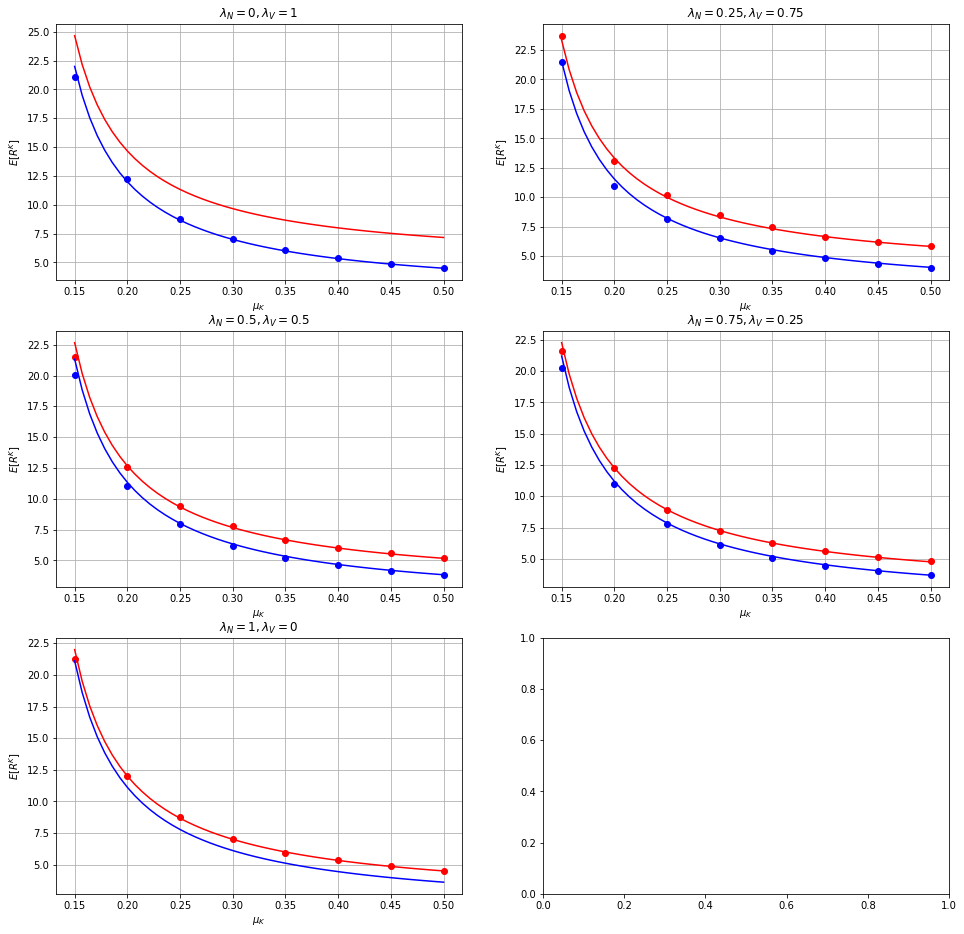

In [15]:
ROWS = 3
COLS = 2

fig, axs = plt.subplots(ROWS, COLS)
fig.set_figheight(16)
fig.set_figwidth(16)

for i, normalRate in enumerate([0, 0.25, 0.5, 0.75, 1]):
    y = i % COLS
    x = i // COLS
    p = axs[x,y]
    
    vipRate = 1 - normalRate
    
    p.set_title(f"$\lambda_N={normalRate}, \lambda_V={vipRate}$")
    p.set_xlabel("$\mu_K$")
    p.set_ylabel("$E[R^K]$")

    params = {
        "**.randFunc": "exp",
        "**.customerSpawn.normalRate": normalRate,
        "**.kitchen.queueType": "fifo",
        "**.customerSpawn.pCompound": 0.1,
    }

    for rate in [0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]:
        params["**.kitchen.rate"] = rate
        for vip in [True, False]:
            avg = get_avg_rt(find_run(**params), vip, True)
            

            p.plot(rate, avg, ('bo' if vip else 'ro'))

    rates = np.linspace(0.15,0.5)
    p.plot(rates, hol_resp_time(False, normalRate, vipRate, 1.5) + mm1_resp_time(0.1, rates), 'r-')
    p.plot(rates, hol_resp_time(True, normalRate, vipRate, 1.5) + mm1_resp_time(0.1, rates), 'b-')
    
    p.grid(True, 'both')

## Response Time (p90)

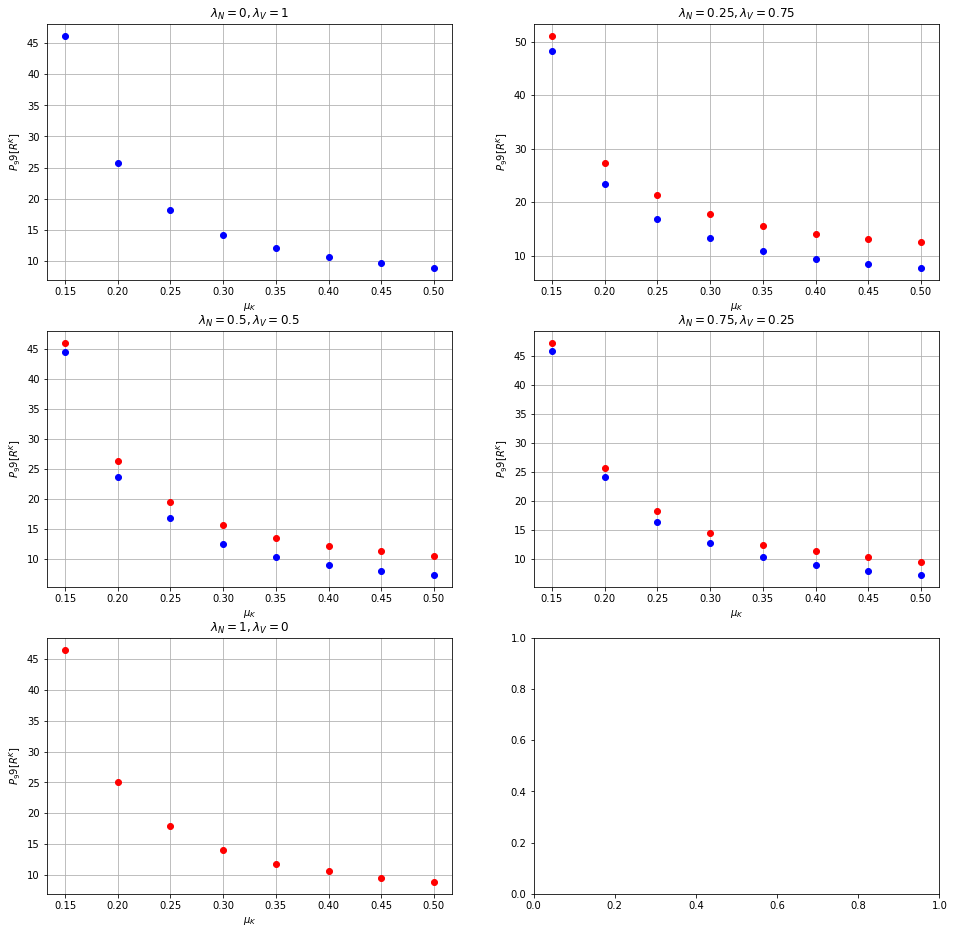

In [16]:
ROWS = 3
COLS = 2

fig, axs = plt.subplots(ROWS, COLS)
fig.set_figheight(16)
fig.set_figwidth(16)

for i, normalRate in enumerate([0, 0.25, 0.5, 0.75, 1]):
    y = i % COLS
    x = i // COLS
    p = axs[x,y]

    vipRate = 1 - normalRate

    p.set_title(f"$\lambda_N={normalRate}, \lambda_V={vipRate}$")
    p.set_xlabel("$\mu_K$")
    p.set_ylabel("$P_99[R^K]$")

    params = {
        "**.randFunc": "exp",
        "**.cashier.rate": 1.5,
        "**.customerSpawn.normalRate": normalRate,
        "**.customerSpawn.pCompound": 0.1,
        "**.kitchen.queueType": "fifo",
    }

    for rate in [0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]:
        params["**.kitchen.rate"] = rate
        for vip in [True, False]:
            arr = get_rt(find_run(**params), vip, True)
            if arr.size == 0:
                continue
            p90 = np.percentile(arr, 90)

            p.plot(rate, p90, ('bo' if vip else 'ro'))
        
        p.grid(True, 'both')

## Waiting Time

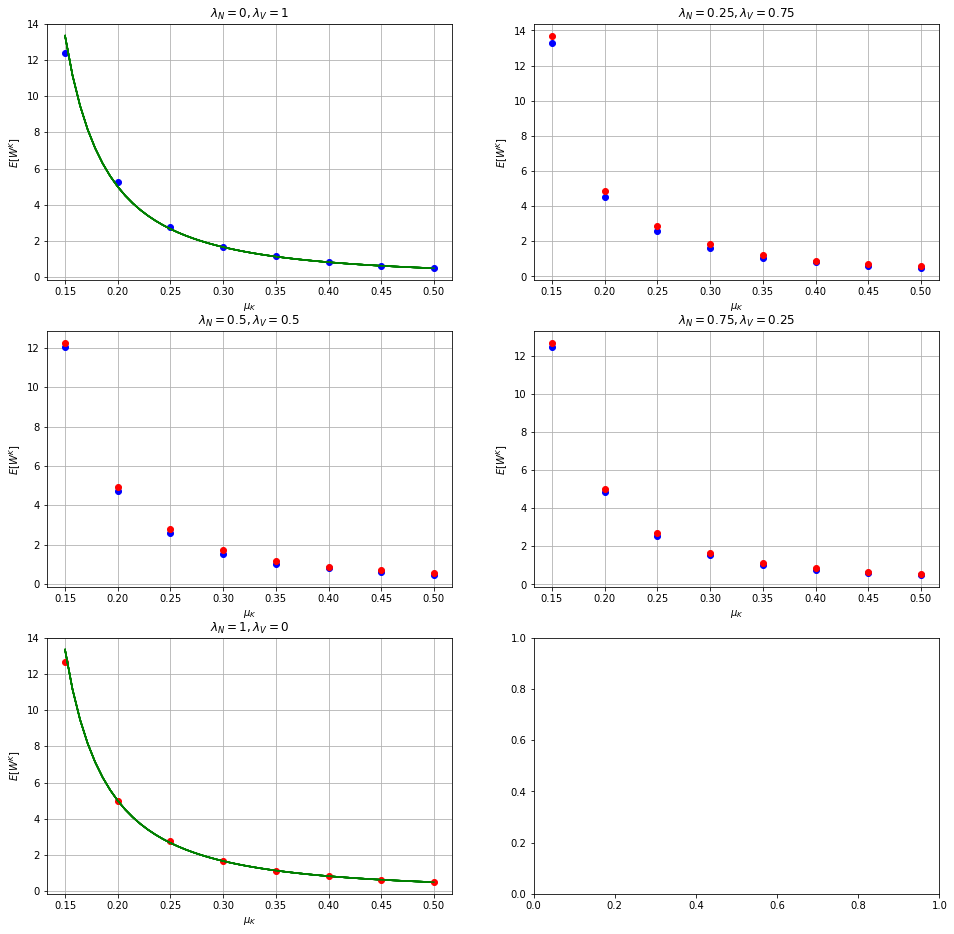

In [26]:
ROWS = 3
COLS = 2

fig, axs = plt.subplots(ROWS, COLS)
fig.set_figheight(16)
fig.set_figwidth(16)

for i, normalRate in enumerate([0, 0.25, 0.5, 0.75, 1]):
    y = i % COLS
    x = i // COLS
    p = axs[x,y]
    
    vipRate = 1 - normalRate
    
    p.set_title(f"$\lambda_N={normalRate}, \lambda_V={vipRate}$")
    p.set_xlabel("$\mu_K$")
    p.set_ylabel("$E[W^K]$")

    params = {
        "**.randFunc": "exp",
        "**.customerSpawn.normalRate": normalRate,
        "**.customerSpawn.pCompound": 0.1,
        "**.kitchen.queueType": "fifo",
    }

    for rate in [0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]:
        params["**.kitchen.rate"] = rate
        for vip in [True, False]:
            avg = get_avg_wt(find_run(**params), 'Network.kitchen', vip)

            p.plot(rate, avg, ('bo' if vip else 'ro'))
            
        if normalRate == 0 or normalRate == 1:
            rates = np.linspace(0.15,0.5)
            p.plot(rates, mm1_wait_time(0.1, rates), 'g-')
    
    p.grid(True, 'both')

## Queue Length

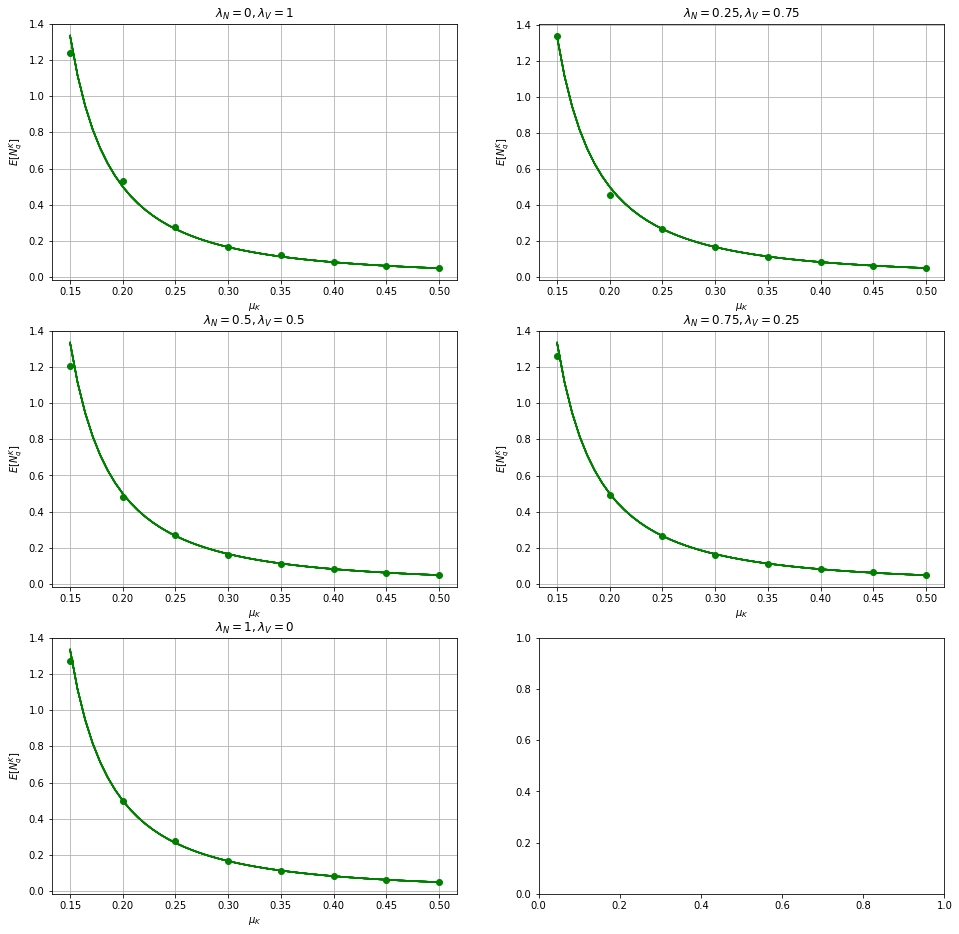

In [18]:
ROWS = 3
COLS = 2

fig, axs = plt.subplots(ROWS, COLS)
fig.set_figheight(16)
fig.set_figwidth(16)

for i, normalRate in enumerate([0, 0.25, 0.5, 0.75, 1]):
    y = i % COLS
    x = i // COLS
    p = axs[x,y]
    
    vipRate = 1 - normalRate
    
    p.set_title(f"$\lambda_N={normalRate}, \lambda_V={vipRate}$")
    p.set_xlabel("$\mu_K$")
    p.set_ylabel("$E[N_q^K]$")

    params = {
        "**.randFunc": "exp",
        "**.customerSpawn.normalRate": normalRate,
        "**.customerSpawn.pCompound": 0.1,
        "**.kitchen.queueType": "fifo",
    }

    for rate in [0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]:
        params["**.kitchen.rate"] = rate
        avg = get_avg_nq(find_run(**params), 'Network.kitchen', fifo=True)

        p.plot(rate, avg, 'go')

        rates = np.linspace(0.15,0.5)
        p.plot(rates, mm1_queue_length(0.1, rates), 'g-')
        
    p.grid(True, 'both')

# Test 4b (PRIO kitchen)

## Response Time (mean)

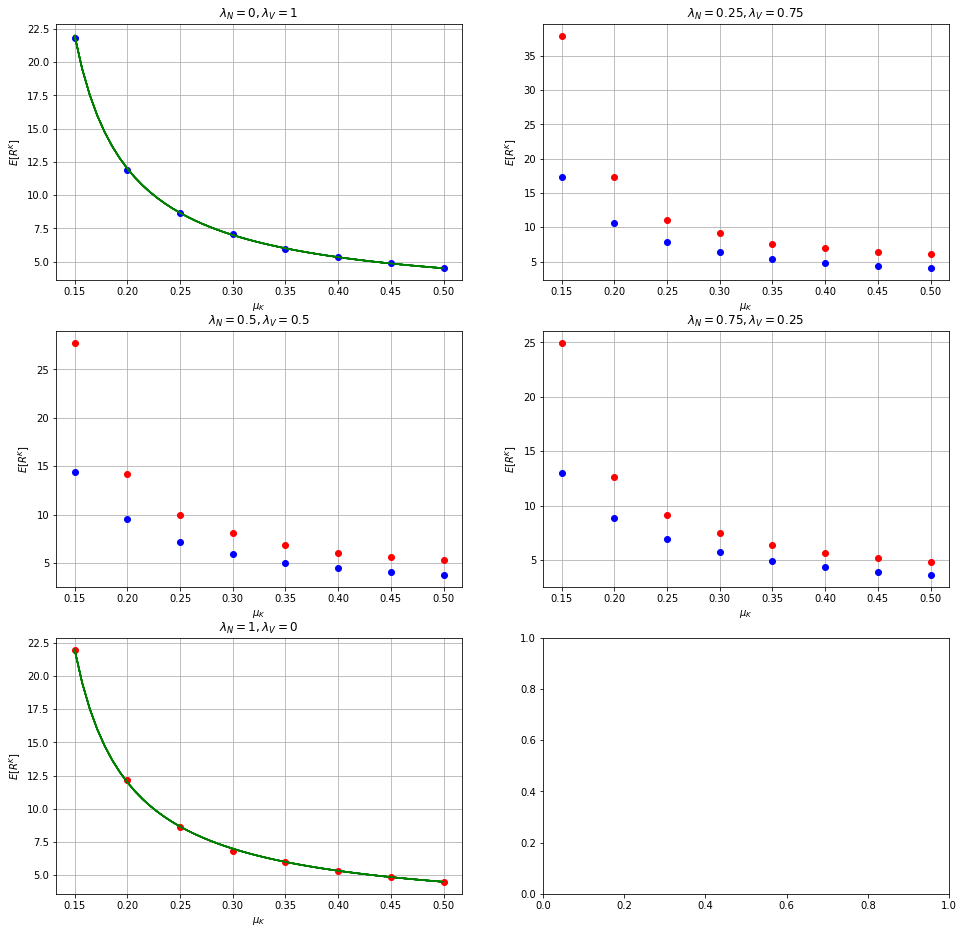

In [19]:
ROWS = 3
COLS = 2

fig, axs = plt.subplots(ROWS, COLS)
fig.set_figheight(16)
fig.set_figwidth(16)

for i, normalRate in enumerate([0, 0.25, 0.5, 0.75, 1]):
    y = i % COLS
    x = i // COLS
    p = axs[x,y]
    
    vipRate = 1 - normalRate
    
    p.set_title(f"$\lambda_N={normalRate}, \lambda_V={vipRate}$")
    p.set_xlabel("$\mu_K$")
    p.set_ylabel("$E[R^K]$")

    params = {
        "**.randFunc": "exp",
        "**.customerSpawn.normalRate": normalRate,
        "**.kitchen.queueType": "priority",
        "**.customerSpawn.pCompound": 0.1,
    }

    for rate in [0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]:
        params["**.kitchen.rate"] = rate
        for vip in [True, False]:
            avg = get_avg_rt(find_run(**params), vip, True)
            

            p.plot(rate, avg, ('bo' if vip else 'ro'))
            
        if normalRate == 0 or normalRate == 1:
            rates = np.linspace(0.15, 0.5)
            p.plot(rates, mm1_resp_time(1, 1.5) + mm1_resp_time(0.1, rates), 'g-')
            
    p.grid(True, 'both')

## Response Time (p90)

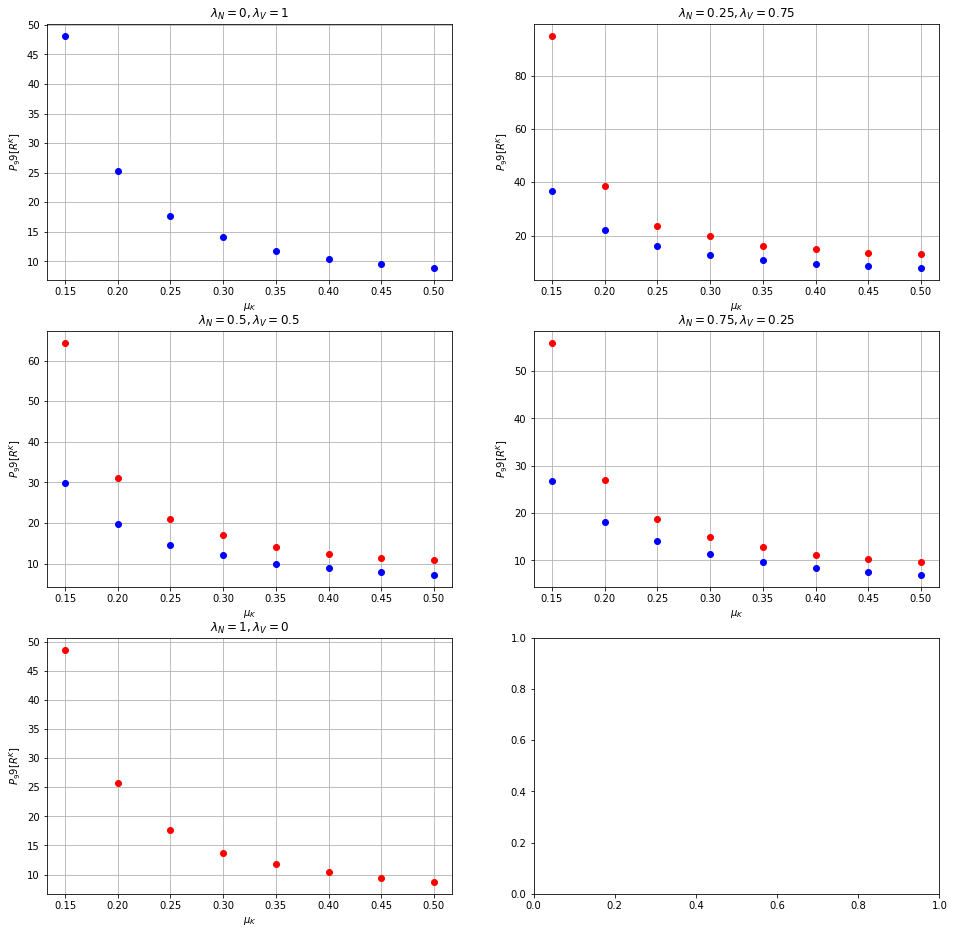

In [20]:
ROWS = 3
COLS = 2

fig, axs = plt.subplots(ROWS, COLS)
fig.set_figheight(16)
fig.set_figwidth(16)

for i, normalRate in enumerate([0, 0.25, 0.5, 0.75, 1]):
    y = i % COLS
    x = i // COLS
    p = axs[x,y]

    vipRate = 1 - normalRate

    p.set_title(f"$\lambda_N={normalRate}, \lambda_V={vipRate}$")
    p.set_xlabel("$\mu_K$")
    p.set_ylabel("$P_99[R^K]$")

    params = {
        "**.randFunc": "exp",
        "**.cashier.rate": 1.5,
        "**.customerSpawn.normalRate": normalRate,
        "**.customerSpawn.pCompound": 0.1,
        "**.kitchen.queueType": "priority",
    }

    for rate in [0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]:
        params["**.kitchen.rate"] = rate
        for vip in [True, False]:
            arr = get_rt(find_run(**params), vip, True)
            if arr.size == 0:
                continue
            p90 = np.percentile(arr, 90)

            p.plot(rate, p90, ('bo' if vip else 'ro'))
        
        p.grid(True, 'both')

# Waiting Time

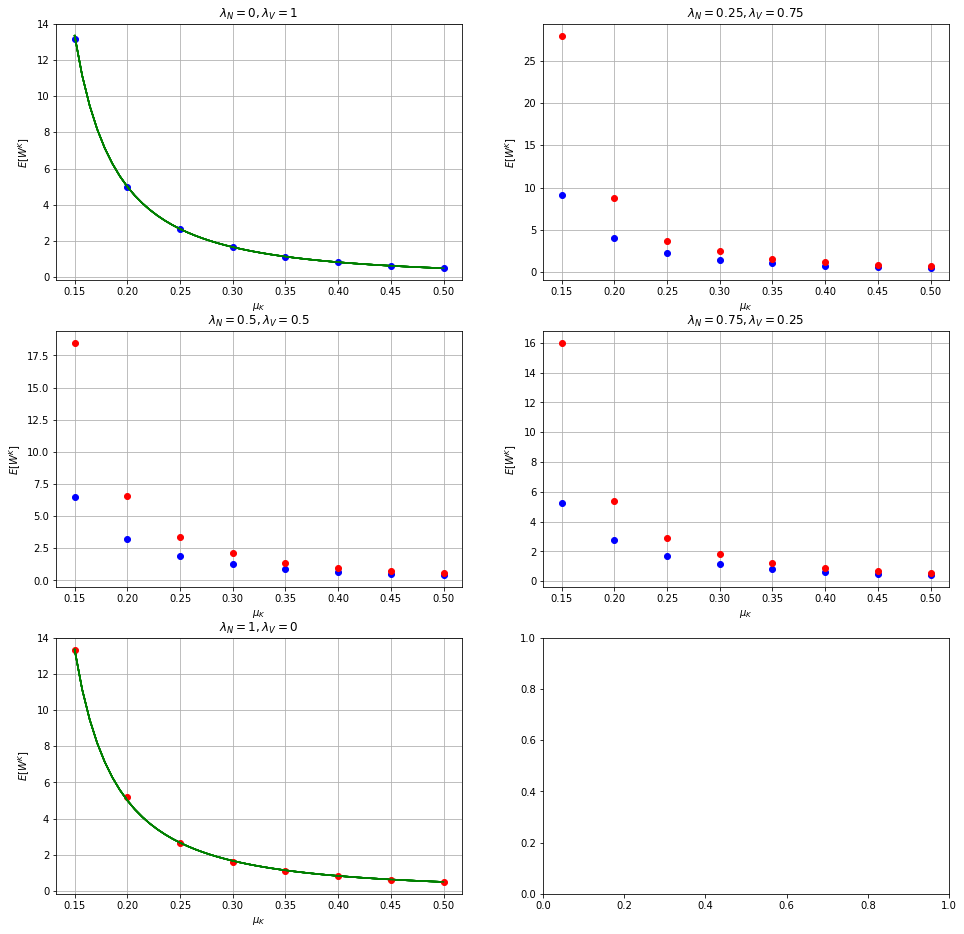

In [27]:
ROWS = 3
COLS = 2

fig, axs = plt.subplots(ROWS, COLS)
fig.set_figheight(16)
fig.set_figwidth(16)

for i, normalRate in enumerate([0, 0.25, 0.5, 0.75, 1]):
    y = i % COLS
    x = i // COLS
    p = axs[x,y]
    
    vipRate = 1 - normalRate
    
    p.set_title(f"$\lambda_N={normalRate}, \lambda_V={vipRate}$")
    p.set_xlabel("$\mu_K$")
    p.set_ylabel("$E[W^K]$")

    params = {
        "**.randFunc": "exp",
        "**.customerSpawn.normalRate": normalRate,
        "**.customerSpawn.pCompound": 0.1,
        "**.kitchen.queueType": "priority",
    }

    for rate in [0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]:
        params["**.kitchen.rate"] = rate
        for vip in [True, False]:
            avg = get_avg_wt(find_run(**params), 'Network.kitchen', vip)

            p.plot(rate, avg, ('bo' if vip else 'ro'))
            
        if normalRate == 0 or normalRate == 1:
            rates = np.linspace(0.15,0.5)
            p.plot(rates, mm1_wait_time(0.1, rates), 'g-')
            
    p.grid(True, 'both')

# Queue Length

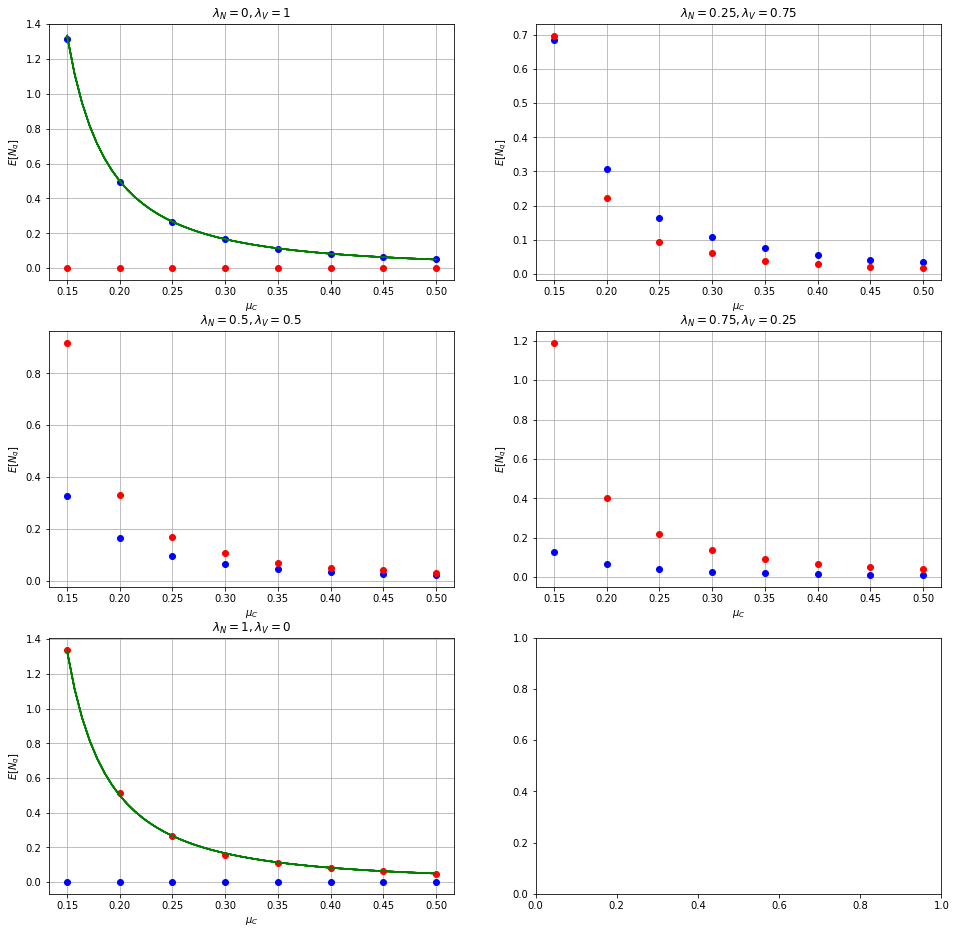

In [22]:
ROWS = 3
COLS = 2

fig, axs = plt.subplots(ROWS, COLS)
fig.set_figheight(16)
fig.set_figwidth(16)

for i, normalRate in enumerate([0, 0.25, 0.5, 0.75, 1]):
    y = i % COLS
    x = i // COLS
    p = axs[x,y]
    
    vipRate = 1 - normalRate
    
    p.set_title(f"$\lambda_N={normalRate}, \lambda_V={vipRate}$")
    p.set_xlabel("$\mu_C$")
    p.set_ylabel("$E[N_q]$")

    params = {
        "**.randFunc": "exp",
        "**.customerSpawn.normalRate": normalRate,
        "**.customerSpawn.pCompound": 0.1,
        "**.kitchen.queueType": "priority",
    }

    for rate in [0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]:
        params["**.kitchen.rate"] = rate
        for vip in [True, False]:
            avg = get_avg_nq(find_run(**params), 'Network.kitchen', vip)

            p.plot(rate, avg, ('bo' if vip else 'ro'))

        if normalRate == 0 or normalRate == 1:
            rates = np.linspace(0.15,0.5)
            p.plot(rates, mm1_queue_length(0.1, rates), 'g-')
        
    p.grid(True, 'both')

In [23]:
params = {
    "**.randFunc": "exp",
    "**.customerSpawn.normalRate": 0,
    "**.customerSpawn.pCompound": 0.1,
    "**.kitchen.queueType": "priority",
    "**.kitchen.rate": 0.5,
}
print(find_run(**params))
print((get_avg_nq(find_run(**params), "Network.kitchen", True)))
print(get_scalar(find_run(**params), ""))

plt.hist(get_wt(find_run(**params), "Network.kitchen", True))

Test4b-15-20191229-22:13:33-40863
0.05010425970966901


TypeError: get_scalar() missing 1 required positional argument: 'name'